<h3>Feature importance by gender</h3>

<h5>Load the dataset</h5>

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

# load adhd dataset
df = pd.read_csv('questionnaire_dataset.csv', sep=';')
feature_cols = desired_columns = ['gender', 'group'] + [f'tr{i}' for i in range(1, 44)] + [f'dass{i}' for i in range(1, 22)]
df = df[feature_cols].copy()

<h5>Screening questionnaire based on previous analysis</h5>

In [531]:
# load the screening questionnaire 
screening_questions = pd.read_csv('screening_questions.csv', sep=';')
screening_questions

,Critère DSM-5,English Item (Author's suggestion),question_code,dsm5_criteria,symptom_category
0,B,I have trouble maintaining my attention at work.,tr4,Often has difficulty sustaining attention in t...,inattention
1,B,I have trouble staying focused during conversa...,tr6,Often has difficulty sustaining attention in t...,inattention
2,C,"My mind is often elsewhere, even when there is...",tr8,Often does not seem to listen when spoken to d...,inattention
3,D,I have difficulty complying with instructions,tr9,Often does not follow through on instructions ...,inattention
4,D,I have difficulty staying focused during my ac...,tr11,Often does not follow through on instructions ...,inattention
5,E,My work is often messy or disorganized,tr13,Often has difficulty organizing tasks and acti...,inattention
6,E,It is difficult for me to organize tasks that ...,tr14,Often has difficulty organizing tasks and acti...,inattention
7,F,I tend to avoid tasks that require sustained m...,tr15,"Often avoids, dislikes, or is reluctant to eng...",inattention
8,G (I),I often lose things I need for my daily life,tr18,Often loses things necessary for tasks or acti...,inattention
9,G,I often lose things I need for my work,tr19,Often loses things necessary for tasks or acti...,inattention


<h5>Balance the dataset using ADASYN</h5>

In [532]:
adasyn = ADASYN(random_state=42)
X = df.copy().drop(columns=['gender'])
y = df['gender'].copy() # men = 1 / women = 0
# apply ADASYN oversampling to balance the dataset
X_balanced, y_balanced = adasyn.fit_resample(X, y)
balanced_df = pd.concat([y_balanced, X_balanced], axis=1)
balanced_df.describe()

,gender,group,tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,...,dass12,dass13,dass14,dass15,dass16,dass17,dass18,dass19,dass20,dass21
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,...,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,0.502809,0.483146,3.553371,3.730337,4.797753,4.446629,3.904494,3.750000,3.334270,4.280899,...,1.561798,1.435393,1.311798,1.019663,0.772472,1.429775,1.629213,1.095506,1.039326,1.205056
std,0.500696,0.500419,1.585130,1.523628,1.421602,1.404205,1.529754,1.670582,1.696078,1.618476,...,1.006515,0.877760,0.952965,0.971223,0.826617,1.017099,0.962766,1.049148,1.047397,1.090330
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000,3.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


<h5>Split the balanced dataset by gender for train, test sets</h5>

In [533]:
# split the dataset by gender 
balanced_df_women = balanced_df[balanced_df['gender'] == 0]
balanced_df_men = balanced_df[balanced_df['gender'] == 1]

In [534]:
# split it further into features and target variable
X_women = balanced_df_women.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_women = balanced_df_women['group'].copy() # adhd = 1 / no adhd = -1

X_men = balanced_df_men.copy().drop(columns=['group', 'gender']).filter(regex='tr')
y_men = balanced_df_men['group'].copy() # adhd = 1 / no adhd = -1

In [535]:
# further filter the features to extract only the ones in the narrowed down version of the questionnaire
screening_qs_codes = screening_questions['question_code'].unique()
X_women = X_women.filter(items=screening_qs_codes, axis=1)
X_men = X_men.filter(items=screening_qs_codes, axis=1)

<h5>Split the data further into Train, Test and Validation sets</h5>
<p>
Further division of the dataset into training, test and validation set is a common technique used to improve models without data leakage. 

The training set is used to train the model.
The validation set is used to evaluate the performance of the model during training and fine-tune it's hyperparameters.

The test set is used to evaluate the final performance of the trained model. It represents unseen data that the model hasn't encountered during training or validation. Using a test set allows for unbiased estimate of the model's performance in real-world scenario.
</p>

In [536]:
# stratified splitting to preserve a balanced class split according to diagnosis
# women
X_train_val_women, X_test_women, y_train_val_women, y_test_women = train_test_split(X_women, y_women, test_size=0.1, stratify=y_women, random_state=42) 
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_val_women, y_train_val_women, test_size=0.25, stratify=y_train_val_women, random_state=42) 

# men
X_train_val_men, X_test_men, y_train_val_men, y_test_men = train_test_split(X_men, y_men, test_size=0.1, stratify=y_men, random_state=42) 
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_val_men, y_train_val_men, test_size=0.25, stratify=y_train_val_men, random_state=42) 

<h3>Logistic Regression</h3>
<p>
Logistic Regression is a linear model used for binary classification tasks. It models the probability that a given input belongs to a particular class using a logistic function. 

It requires numerical input features. Categorical features may need to be encoded. 

Logistic Regression outputs probabilities of class membership for each input instance. These probabilities can be thresholded to make binary predictions.
</p>

<h5>Logistic Regression for Women</h5>

In [537]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
logistic_reg = LogisticRegression(max_iter=1000, random_state=32, solver='liblinear')
# perform cross-validated grid search
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)
# get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# initialize Logistic Regression with best parameters
best_logistic_reg = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=32)

# fit the model on the entire training set
best_logistic_reg.fit(X_train_women, y_train_women)

# extract feature importances
feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'C': 1, 'penalty': 'l1'}
Feature Importances:
Feature tr19: 1.0148912706045878
Feature tr20: 0.6494270085076819
Feature tr15: 0.5559566580698377
Feature tr8: 0.5304391674450408
Feature tr28: 0.44605418480663245
Feature tr40: 0.31516705923220983
Feature tr18: 0.2462545942224518
Feature tr14: 0.22286025799238715
Feature tr6: 0.1966890569032907
Feature tr9: 0.16364069439389492
Feature tr21: 0.16177753802014486
Feature tr35: 0.12655735409054059
Feature tr13: 0.035811275828634935
Feature tr34: 0.016990910173965822
Feature tr4: 0.0
Feature tr29: 0.0
Feature tr11: 0.0


In [538]:
y_pred_women = best_logistic_reg.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.8
precision: 0.7894736842105263
recall: 0.7894736842105263
f1: 0.7894736842105263
roc_auc: 0.7994987468671679


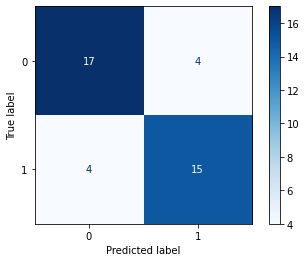

In [539]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_logistic_reg.classes_)
disp.plot(cmap='Blues')

<h5>Logistic Regression for Men</h5>

In [540]:
# define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'], # l1 lasso l2 ridge
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
logistic_reg = LogisticRegression(max_iter=1000, random_state=32, solver='liblinear')
# perform cross-validated grid search
grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)
# get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# initialize Logistic Regression with best parameters
best_logistic_reg = LogisticRegression(**best_params, solver='liblinear', max_iter=1000, random_state=32)

# fit the model on the entire training set
best_logistic_reg.fit(X_train_men, y_train_men)

# extract feature importances
feature_importances = np.abs(best_logistic_reg.coef_).sum(axis=0)

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'C': 0.5, 'penalty': 'l1'}
Feature Importances:
Feature tr34: 1.2549191415450704
Feature tr9: 0.9153757738677489
Feature tr40: 0.6154284545010529
Feature tr35: 0.5715383395303287
Feature tr20: 0.5638074509140043
Feature tr6: 0.5204153885551726
Feature tr15: 0.44101374018424444
Feature tr18: 0.11255457345108182
Feature tr4: 0.0511466170158001
Feature tr28: 0.03338583849118335
Feature tr29: 0.005406809830899119
Feature tr8: 0.0
Feature tr21: 0.0
Feature tr19: 0.0
Feature tr14: 0.0
Feature tr13: 0.0
Feature tr11: 0.0


In [542]:
y_pred_men = best_logistic_reg.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.975609756097561
precision: 0.9523809523809523
recall: 1.0
f1: 0.975609756097561
roc_auc: 0.9761904761904762


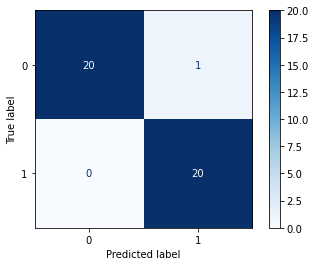

In [543]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_logistic_reg.classes_)
disp.plot(cmap='Blues')

<h3>AdaBoost</h3>
<p>
AdaBoost is an ensemble learning method that combines multiple weak classifier to create a strong classifier. It iteratively trains a series of weak learners, each focusing on the instances that were misclassified by the previous ones.

It can handle both numerical and categorical features. No specific preprocessing is required, but missing values may need to be handled. 

AdaBoost outputs class labels for classification tasks. It can also provide information about the weights assigned to each weak learner and their contribution to the final decision. 
</p>

<h5>AdaBoost for Women</h5>

In [544]:
param_grid = {
    'n_estimators': [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'] 
}
adaboost = AdaBoostClassifier(random_state=42)

grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_adaboost = AdaBoostClassifier(**best_params, random_state=32)

# fit the model on the entire training set
best_adaboost.fit(X_train_women, y_train_women)

feature_importances = best_adaboost.feature_importances_

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 10}
Feature Importances:
Feature tr8: 0.5454578995808739
Feature tr21: 0.20733814743048962
Feature tr28: 0.15494693538168125
Feature tr15: 0.09225701760695527
Feature tr9: 0.0
Feature tr6: 0.0
Feature tr40: 0.0
Feature tr4: 0.0
Feature tr35: 0.0
Feature tr34: 0.0
Feature tr29: 0.0
Feature tr20: 0.0
Feature tr19: 0.0
Feature tr18: 0.0
Feature tr14: 0.0
Feature tr13: 0.0
Feature tr11: 0.0


In [545]:
y_pred_women = best_adaboost.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.65
precision: 0.6086956521739131
recall: 0.7368421052631579
f1: 0.6666666666666666
roc_auc: 0.6541353383458646


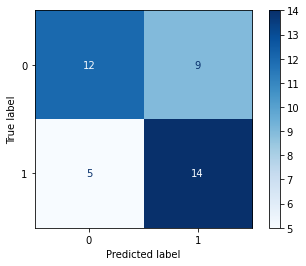

In [546]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h5>AdaBoost for Men</h5>

In [547]:
param_grid = {
    'n_estimators': [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R'] 
}
adaboost = AdaBoostClassifier(random_state=42)

grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_adaboost = AdaBoostClassifier(**best_params, random_state=32)

# fit the model on the entire training set
best_adaboost.fit(X_train_men, y_train_men)

feature_importances = best_adaboost.feature_importances_

print("Feature Importances:")
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 500}
Feature Importances:
Feature tr6: 0.3243961970320875
Feature tr21: 0.27626472562400056
Feature tr34: 0.13471103545459379
Feature tr9: 0.09914362028980021
Feature tr4: 0.0554358988839974
Feature tr14: 0.0368726895168999
Feature tr35: 0.033474002031280016
Feature tr18: 0.021803015231413373
Feature tr8: 0.01176318787518278
Feature tr13: 0.00613562806074435
Feature tr40: 0.0
Feature tr29: 0.0
Feature tr28: 0.0
Feature tr20: 0.0
Feature tr19: 0.0
Feature tr15: 0.0
Feature tr11: 0.0


In [548]:
y_pred_men = best_adaboost.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9512195121951219
precision: 1.0
recall: 0.9
f1: 0.9473684210526316
roc_auc: 0.95


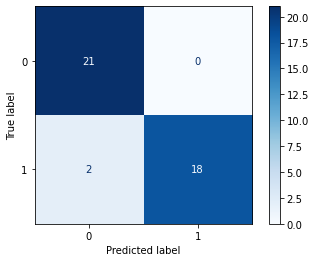

In [549]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h3>Support Vector Machine</h3>
<p>
SVM is a supervised learning algorithm that constructs a hyperplane or set of hyperplanes in a high-dimensional space to separate classes. It's effective in high-dimensional spaces and for cases where the number of dimensions exceeds the number of samples. 

It works best with numerical input features. Feature scaling is recommended, and categorical variables may need to be encoded.

SVM outputs class labels for classification tasks. It can also provide information about the separating hyperplane(s) and support vectors, which are the data points closest to the decision boundary.
</p>

<h5>Support Vector Machine for Women</h5>

In [550]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=32)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=32)

best_svm.fit(X_train_women, y_train_women)

Best parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


SVC(C=0.1, gamma=0.01, random_state=32)

In [551]:
perm_importance = permutation_importance(best_svm, X_train_women, y_train_women, n_repeats=10, random_state=42)
feature_importance_scores = perm_importance.importances_mean
for importance, feature in sorted(zip(feature_importance_scores, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr21: 0.015966386554621802
Feature tr9: 0.015126050420168036
Feature tr15: 0.012605042016806688
Feature tr14: 0.011764705882352922
Feature tr8: 0.010924369747899131
Feature tr4: 0.009243697478991564
Feature tr29: 0.003361344537815092
Feature tr40: 0.0025210084033612913
Feature tr35: 0.001680672268907546
Feature tr13: 0.001680672268907546
Feature tr28: 0.001680672268907535
Feature tr19: 0.0016806722689075237
Feature tr18: 0.0
Feature tr11: -1.1102230246251566e-17
Feature tr34: -3.3306690738754695e-17
Feature tr20: -0.0008403361344537896
Feature tr6: -0.002521008403361369


In [553]:
y_pred_women = best_svm.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.825
precision: 0.7727272727272727
recall: 0.8947368421052632
f1: 0.8292682926829269
roc_auc: 0.8283208020050125


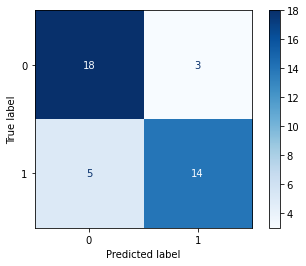

In [528]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h5>Support Vector Machine for Men</h5>

In [502]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}  

svm = SVC(random_state=32)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_svm = SVC(**best_params, random_state=32)

best_svm.fit(X_train_men, y_train_men)

y_pred_men = best_svm.predict(X_val_men)

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}


In [529]:
perm_importance = permutation_importance(best_svm, X_train_men, y_train_men, n_repeats=10, random_state=42)
feature_importance_scores = perm_importance.importances_mean
for importance, feature in sorted(zip(feature_importance_scores, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr6: 0.16416666666666663
Feature tr34: 0.15249999999999994
Feature tr15: 0.0991666666666666
Feature tr9: 0.08749999999999994
Feature tr4: 0.06666666666666661
Feature tr35: 0.039999999999999945
Feature tr14: 0.03666666666666661
Feature tr13: 0.03499999999999994
Feature tr8: 0.02999999999999995
Feature tr29: 0.01749999999999997
Feature tr40: 0.010833333333333283
Feature tr21: 0.009999999999999964
Feature tr28: 0.0058333333333333015
Feature tr18: 0.003333333333333288
Feature tr20: 0.002499999999999991
Feature tr19: 0.0
Feature tr11: 0.0


In [503]:
y_pred_men = best_svm.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.926829268292683
precision: 0.9047619047619048
recall: 0.95
f1: 0.9268292682926829
roc_auc: 0.9273809523809523


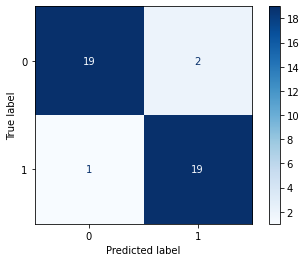

In [504]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_adaboost.classes_)
disp.plot(cmap='Blues')

<h3>Random Forrest</h3>
<p>
Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

It can handle both numerical and categorical features. No specific preprocessing is required, but missing values may need to be handled.

Random Forest outputs class labels for classification tasks or continuous values for regression tasks. Additionally, it can provide feature importances, which indicate the relative importance of each feature in the model.
</p>

<h5>Random Forrest for Women</h5>

In [505]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf_classifier = RandomForestClassifier(random_state=32)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf_classifier = RandomForestClassifier(**best_params, random_state=32)

best_rf_classifier.fit(X_train_women, y_train_women)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=4, n_estimators=200, random_state=32)

In [558]:
feature_importances = best_rf_classifier.feature_importances_
for importance, feature in sorted(zip(feature_importances, X_train_women.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr21: 0.1966141759380472
Feature tr6: 0.14758893816816326
Feature tr34: 0.1113516545033256
Feature tr40: 0.09639477739873482
Feature tr14: 0.0691854056207095
Feature tr15: 0.05882003565200915
Feature tr19: 0.047988506704041985
Feature tr18: 0.04026587800308249
Feature tr35: 0.03871963262907963
Feature tr28: 0.03650766151695192
Feature tr29: 0.031585435617194665
Feature tr4: 0.02702585795426328
Feature tr8: 0.0254229594919308
Feature tr9: 0.022236190761825134
Feature tr13: 0.02127799707839991
Feature tr11: 0.015197961428241227
Feature tr20: 0.013816931533999438


In [506]:
y_pred_women = best_rf_classifier.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.825
precision: 0.8
recall: 0.8421052631578947
f1: 0.8205128205128205
roc_auc: 0.8258145363408521


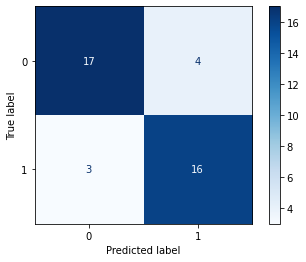

In [507]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h5>Random Forrest for Men</h5>

In [508]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

rf_classifier = RandomForestClassifier(random_state=32)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_rf_classifier = RandomForestClassifier(**best_params, random_state=32)

best_rf_classifier.fit(X_train_men, y_train_men)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=32)

In [559]:
feature_importances = best_rf_classifier.feature_importances_
for importance, feature in sorted(zip(feature_importances, X_train_men.columns), reverse=True):
    print(f"Feature {feature}: {importance}")

Feature tr21: 0.1966141759380472
Feature tr6: 0.14758893816816326
Feature tr34: 0.1113516545033256
Feature tr40: 0.09639477739873482
Feature tr14: 0.0691854056207095
Feature tr15: 0.05882003565200915
Feature tr19: 0.047988506704041985
Feature tr18: 0.04026587800308249
Feature tr35: 0.03871963262907963
Feature tr28: 0.03650766151695192
Feature tr29: 0.031585435617194665
Feature tr4: 0.02702585795426328
Feature tr8: 0.0254229594919308
Feature tr9: 0.022236190761825134
Feature tr13: 0.02127799707839991
Feature tr11: 0.015197961428241227
Feature tr20: 0.013816931533999438


In [509]:
y_pred_men = best_rf_classifier.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9512195121951219
precision: 0.95
recall: 0.95
f1: 0.9500000000000001
roc_auc: 0.9511904761904761


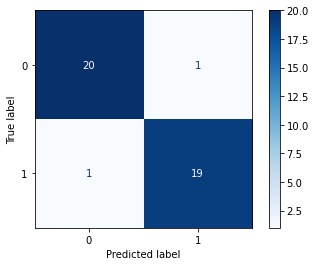

In [510]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h3>k-Nearest Neighbours (KNN)</h3>
<p>
KNN is a non-parametric and instance-based learning algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions).

It works best with numerical input features. Feature scaling is essential as it's based on computing distances between data points. Categorical variables may need to be encoded.

KNN outputs class labels for classification tasks based on the majority class among the k-nearest neighbors of the new instance.
</p>

<h5>k-Nearest Neighbours (KNN) for Women</h5>

In [511]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_women, y_train_women)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_knn_classifier = KNeighborsClassifier(**best_params)

best_knn_classifier.fit(X_train_women, y_train_women)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


KNeighborsClassifier(metric='euclidean', n_neighbors=9)

In [512]:
y_pred_women = best_knn_classifier.predict(X_val_women)

# compute evaluation metrics
accuracy = accuracy_score(y_val_women, y_pred_women)
precision = precision_score(y_val_women, y_pred_women)
recall = recall_score(y_val_women, y_pred_women)
f1 = f1_score(y_val_women, y_pred_women)
roc_auc = roc_auc_score(y_val_women, y_pred_women)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.8
precision: 0.7619047619047619
recall: 0.8421052631578947
f1: 0.8
roc_auc: 0.8020050125313283


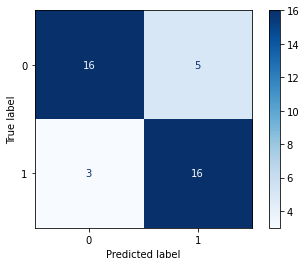

In [513]:
conf_matrix = confusion_matrix(y_val_women, y_pred_women)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h5>k-Nearest Neighbours (KNN) for Men</h5>

In [514]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],     
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_men, y_train_men)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_knn_classifier = KNeighborsClassifier(**best_params)

best_knn_classifier.fit(X_train_men, y_train_men)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [515]:
y_pred_men = best_rf_classifier.predict(X_val_men)

# compute evaluation metrics
accuracy = accuracy_score(y_val_men, y_pred_men)
precision = precision_score(y_val_men, y_pred_men)
recall = recall_score(y_val_men, y_pred_men)
f1 = f1_score(y_val_men, y_pred_men)
roc_auc = roc_auc_score(y_val_men, y_pred_men)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'roc_auc: {roc_auc}')

accuracy: 0.9512195121951219
precision: 0.95
recall: 0.95
f1: 0.9500000000000001
roc_auc: 0.9511904761904761


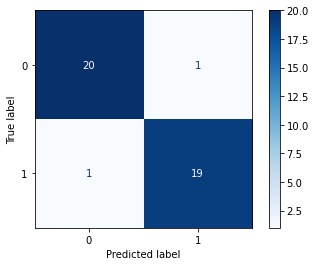

In [516]:
conf_matrix = confusion_matrix(y_val_men, y_pred_men)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=best_rf_classifier.classes_)
disp.plot(cmap='Blues')

<h1>ANYTHING BELOW IS WORK IN PROGRESS</h1>